這份 code 在做商品的前處理

0. 看商品資料：input `SalePage.csv`
1. BERT 取 CLS vec：output `SalePage_bertvecs.csv`
2. MONPA 斷詞：output `SalePage_cutterms.csv`
3. 斷詞後小統計、做字典：output `SalePage_vocab.csv`

In [169]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
tqdm.pandas()  # init 進度條
import gc  # 記憶體的垃圾回收, 用法: gc.collect()
from collections import Counter  # 斷詞小統計
import re # 正規表達式
import unicodedata  # unicode 處理 e.g. 抓標點符號
import matplotlib.pyplot as plt  # 畫圖用
from matplotlib_venn import venn2  # 文氏圖
plt.rcParams['font.family']=['Noto Sans TC'] # 中文顯示

In [11]:
DATA_DIR = 'data'
!ls {DATA_DIR}

SalePage.csv          SalePage_cutterms.csv Three_NAPLNEW(A).csv


### 0. 看一下商品資料
- 商品資料 `SalePage.csv`
- 看商品標題 `SalePageTitle`、商品敘述 `SaleProductDescShortContent` 的字數分布

,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent
0,NOmceSRCGAE2GjCOCwaCrA==,7104874,戰神MARS搖搖杯2.0-600ml-夜幕黑,NaN
1,NOmceSRCGAE2GjCOCwaCrA==,7098357,國太樓伯爵紅茶 28.8g-蘋果風味,日本原裝進口
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠
3,NOmceSRCGAE2GjCOCwaCrA==,7048775,阿華田營養巧克力麥芽飲品 20g*13入,源自瑞士百年麥芽經典\n嚴選優質麥芽精華、濃郁可可及濃醇乳香\n兼顧健康與美味，完美調配營養...
4,NOmceSRCGAE2GjCOCwaCrA==,7076969,曼寧有機蘋香舒緩茶20入,•晚餐後或睡前最好的舒眠飲品\n•帶有蘋果甜蜜香氣的洋甘菊\n•原料來自德國，品質令人信賴
...,...,...,...,...
46240,NOmceSRCGAE2GjCOCwaCrA==,9229146,贈-Biore淨嫩沐浴乳300g櫻花香,贈-Biore淨嫩沐浴乳300g櫻花香
46241,NOmceSRCGAE2GjCOCwaCrA==,9545749,2/28-3/05贈品-氧顏森活微分子乳木果保濕面膜3入,2/28-3/05贈品-氧顏森活微分子乳木果保濕面膜3入
46242,NOmceSRCGAE2GjCOCwaCrA==,9370014,12/06-01/09門市取貨滿$590抽Apple Watch S9 LTE 41mm (...,12/06-01/09門市取貨滿$590抽Apple Watch S9 LTE 41mm (...
46243,NOmceSRCGAE2GjCOCwaCrA==,9288119,【廠商直送】贈-ILOVEPINK抱枕-2入(顏色隨機出貨)-$799,【廠商直送】贈-ILOVEPINK抱枕-2入(顏色隨機出貨)-$799


is title nan? 0
title_length range 1 81


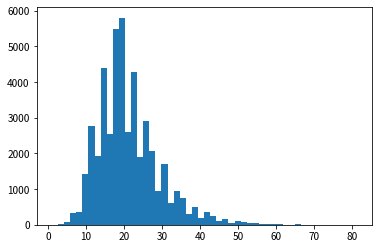

is description nan? 2938
desc_length range 1.0 550.0


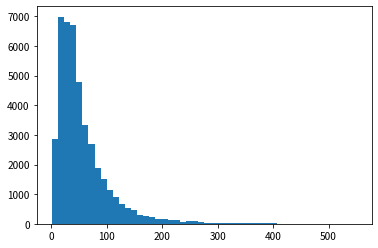

In [11]:
salePage_df = pd.read_csv(f'{DATA_DIR}/SalePage.csv')
display(salePage_df)

# SalePageTitle 字數分布
print("is title nan?", salePage_df['SalePageTitle'].isna().sum())
salePage_df['title_length'] = salePage_df['SalePageTitle'].str.len()
print("title_length range", salePage_df['title_length'].min(), salePage_df['title_length'].max())
plt.hist(salePage_df['title_length'], bins=50)
plt.show()

# SaleProductDescShortContent 字數分布
print("is description nan?", salePage_df['SaleProductDescShortContent'].isna().sum())
salePage_df['desc_length'] = salePage_df['SaleProductDescShortContent'].str.len()
print("desc_length range", salePage_df['desc_length'].min(), salePage_df['desc_length'].max())
plt.hist(salePage_df['desc_length'], bins=50)
plt.show()

### 1. BERT 取 CLS vec (Kaggle)
- input 商品資料 `SalePage.csv`
- output 商品標題、商品敘述、商品標題+敘述的 BERT vec `SalePage_bertvecs.csv`

In [ ]:
# import, env setting
import csv
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)  # notice: GPU P100 5 min, CPU 5 hr

2025-05-23 16:17:44.883993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748017065.066664      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748017065.118597      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda


In [ ]:
# input: read docs
doc_df = pd.read_csv("/kaggle/input/bda-proj-data/SalePage.csv")  # 商品標題與敘述
#doc_df = doc_df[:100]  # small test
print("doc_df", doc_df.shape)
display(doc_df.head(1))

doc_df (46245, 4)


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent
0,NOmceSRCGAE2GjCOCwaCrA==,7104874,戰神MARS搖搖杯2.0-600ml-夜幕黑,NaN


In [ ]:
# transfer: docs texts --BERT--> CLS vecs

# load BERT tokenizer, model
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')
model.to(device)
model.eval()  # eval mode

# input texts --BERT--> output vecs
title_texts = doc_df['SalePageTitle'].fillna('').astype(str).tolist()
desc_texts = doc_df['SaleProductDescShortContent'].fillna('').astype(str).tolist()  # 處理 nan --> ''
all_texts = (doc_df['SalePageTitle'].fillna('') + ' ' + doc_df['SaleProductDescShortContent'].fillna('')).astype(str).tolist()

title_bertvecs = []  # 768 dim for each doc
desc_bertvecs = []
all_bertvecs = []

def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        cls = outputs.last_hidden_state[:, 0, :]  # get [CLS] vec
    return cls.squeeze().cpu().numpy()

for title, desc, alll in tqdm(zip(title_texts, desc_texts, all_texts), total=len(all_texts)):
    title_bertvecs.append(get_cls_embedding(title))
    desc_bertvecs.append(get_cls_embedding(desc))
    all_bertvecs.append(get_cls_embedding(alll))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

100%|██████████| 46245/46245 [44:09<00:00, 17.46it/s]


In [ ]:
# output: save BERT CLS vecs
bert_df = pd.DataFrame({
    'SalePageId': doc_df['SalePageId'],
    'title_bertvecs': title_bertvecs,
    'desc_bertvecs': desc_bertvecs,
    'all_bertvecs': all_bertvecs,
})

bert_df.to_csv('/kaggle/working/SalePage_bertvecs.csv', index=False)
print("bert_df", bert_df.shape)
print("CLS dim", len(bert_df['title_bertvecs'][0]))
display(bert_df.head(1))

bert_df (46245, 4)
CLS dim 768


,SalePageId,title_bertvecs,desc_bertvecs,all_bertvecs
0,7104874,"[-0.54972005, 0.16861996, -0.89927554, 0.23800...","[0.11445117, 0.33425924, -0.33528084, 1.224486...","[-0.54972005, 0.16861996, -0.89927554, 0.23800..."


In [10]:
# AFTER KAGGLE, read in my env
#bert_df = pd.read_csv(f'{DATA_DIR}/SalePage_bertvecs.csv')
#print("bert_df", bert_df.shape)
#display(bert_df.head(1))
print("檔案太大了（1.73 GB），有關 BERT vec 接下來要做的所有事情都改到 Kaggle 上跑")

檔案太大了（1.73 GB），有關 BERT vec 接下來要做的所有事情都改到 Kaggle 上跑


### 2. MONPA 斷詞 (Kaggle)
- input 商品資料 `SalePage.csv`
- output 商品標題、商品敘述的斷詞 `SalePage_cutterms.csv`

In [ ]:
# import
#!pip install monpa
from monpa import cut, utils  # 斷詞
import re  # 正則表達式
import unicodedata  # 標點符號判斷
import pandas as pd
from tqdm import tqdm

In [ ]:
# input: read docs
doc_df = pd.read_csv("/kaggle/input/bda-proj-data/SalePage.csv")  # 商品標題與敘述
#doc_df = doc_df[:100]  # small test
print("doc_df", doc_df.shape)
display(doc_df.head(1))

doc_df (46245, 4)


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent
0,NOmceSRCGAE2GjCOCwaCrA==,7104874,戰神MARS搖搖杯2.0-600ml-夜幕黑,NaN


In [ ]:
# transfer: docs texts --MONPA--> doc terms

# 標點
def is_punctuation(token):
    return all(unicodedata.category(c).startswith('P') for c in token)

# 斷詞
def monpa_tokenize(text):
    if pd.isna(text):
        return ''
    result = []
    for sentence in utils.short_sentence(text):
        tokens = cut(sentence)  # 斷詞
        # 轉小寫, 去掉數字, 去掉標點, 不過濾長度 > 1 (e.g. 想保留 '贈')
        tokens = [t.strip().lower() for t in tokens if not is_punctuation(t) and not re.fullmatch(r'\d+(\.\d+)?', t)]
        result.extend(tokens)
    return ' '.join(result)

tqdm.pandas(desc="Tokenizing title")
doc_df['title_cutterms'] = doc_df['SalePageTitle'].progress_apply(monpa_tokenize)

tqdm.pandas(desc="Tokenizing desc")
doc_df['desc_cutterms'] = doc_df['SaleProductDescShortContent'].progress_apply(monpa_tokenize)

Tokenizing desc: 100%|██████████| 46245/46245 [17:42<00:00, 43.51it/s] 


In [ ]:
# output: save MONPA cut terms
term_df = doc_df[['SalePageId', 'title_cutterms', 'desc_cutterms']]
term_df.to_csv('/kaggle/working/SalePage_cutterms.csv', index=False)
print("term_df", term_df.shape)

display(term_df.head(1))

term_df (46245, 3)
CLS dim 19


,SalePageId,title_cutterms,desc_cutterms
0,7104874,戰神 mars 搖搖杯 ml 夜幕 黑,


In [12]:
# AFTER KAGGLE, read in my env
term_df = pd.read_csv(f'{DATA_DIR}/SalePage_cutterms.csv')
print("term_df", term_df.shape)
display(term_df.head(1))

term_df (46245, 3)


,SalePageId,title_cutterms,desc_cutterms
0,7104874,戰神 mars 搖搖杯 ml 夜幕 黑,NaN


### 3. 斷詞後的小統計
- 看商品標題、商品敘述的 **斷詞數量**
- 看商品標題、商品敘述的 **字典、常用字**

In [14]:
# load: 商品斷詞
term_df = pd.read_csv(f'{DATA_DIR}/SalePage_cutterms.csv')
print("term_df", term_df.shape)
display(term_df.head(1))

term_df (46245, 3)


,SalePageId,title_cutterms,desc_cutterms
0,7104874,戰神 mars 搖搖杯 ml 夜幕 黑,NaN


#### 3-1. 斷詞數量
- 沒有標題的（原始標題是亂碼），敘述可能有 '贈'
- 沒有敘述的，標題可能有 '限時特賣'
- 沒有標體、沒有敘述的，可以刪掉（不刪也不影響）

term_df w/ counts (46245, 5)


,SalePageId,title_cutterms,desc_cutterms,title_term_count,desc_term_count
0,7104874,戰神 mars 搖搖杯 ml 夜幕 黑,NaN,6,0


title_term_count 
range 0 34
mean 7.901481241215267 
median 8.0


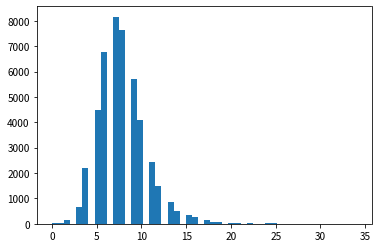

desc_term_count 
range 0 287
mean 23.80028111147151 
median 18.0


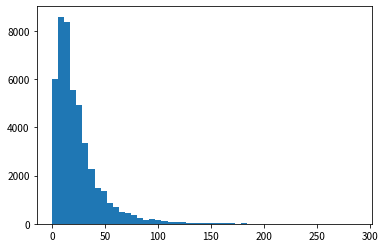

In [54]:
# count: 對每個商品，計算 title 斷詞數量、desc 斷詞數量
def count_terms(term_string):
    if not isinstance(term_string, str):
        return 0
    return len(term_string.split())

term_df['title_term_count'] = term_df['title_cutterms'].apply(count_terms)
term_df['desc_term_count'] = term_df['desc_cutterms'].apply(count_terms)
print("term_df w/ counts", term_df.shape)
display(term_df.head(1))

# 看 title 斷詞數量分布
print("title_term_count \nrange", term_df['title_term_count'].min(), term_df['title_term_count'].max())
print("mean", term_df['title_term_count'].mean(), "\nmedian", term_df['title_term_count'].median())
plt.hist(term_df['title_term_count'], bins=50)
plt.show()

# 看 desc 斷詞數量分布
print("desc_term_count \nrange", term_df['desc_term_count'].min(), term_df['desc_term_count'].max())
print("mean", term_df['desc_term_count'].mean(), "\nmedian", term_df['desc_term_count'].median())
plt.hist(term_df['desc_term_count'], bins=50)
plt.show()

zero_title_terms_df (25, 5)
zero_desc_terms_df (2975, 5)
zero_terms_df (5, 5)
zero_terms_df in zero_title_terms_df? True
zero_terms_df in zero_desc_terms_df? True


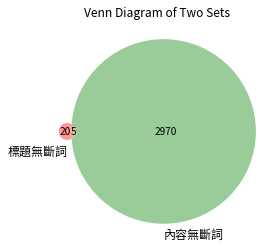

In [60]:
# 抓出斷詞 = 0 的商品

# 看有多少商品的 title 斷詞數量 = 0
zero_title_terms_df = term_df[term_df['title_term_count'] == 0]
print("zero_title_terms_df", zero_title_terms_df.shape)

# 看有多少商品的 desc 斷詞數量 = 0
zero_desc_terms_df = term_df[term_df['desc_term_count'] == 0]
print("zero_desc_terms_df", zero_desc_terms_df.shape)

# 看有多少商品的 title 斷詞數量 + desc 斷詞數量 = 0
zero_terms_df = term_df[(term_df['title_term_count'] == 0) & (term_df['desc_term_count'] == 0)]
print("zero_terms_df", zero_terms_df.shape)
print("zero_terms_df in zero_title_terms_df?", zero_terms_df['SalePageId'].isin(zero_title_terms_df['SalePageId']).all())
print("zero_terms_df in zero_desc_terms_df?", zero_terms_df['SalePageId'].isin(zero_desc_terms_df['SalePageId']).all())

# title, desc 斷詞 = 0 的文氏圖
title0_set = set(zero_title_terms_df['SalePageId'])
desc0_set = set(zero_desc_terms_df['SalePageId'])
venn2([title0_set, desc0_set], set_labels=('標題無斷詞', '內容無斷詞'))
plt.title("Venn Diagram of Two Sets")
plt.show()

In [82]:
# 看一下 title 斷詞數量 = 0 的商品 (看起來是贈品、口罩)
salePage_df[salePage_df['SalePageId'].isin(zero_title_terms_df['SalePageId'].tolist())].drop(columns=['ShopId'])

# 看一下 desc 斷詞數量 = 0 的商品 (標題還是有 '限時特賣' 之類的字眼)
#salePage_df[salePage_df['SalePageId'].isin(zero_desc_terms_df['SalePageId'].tolist())].drop(columns=['ShopId']).head(25)

# 看一下 title + desc 斷詞數量 = 0 的商品
#salePage_df[salePage_df['SalePageId'].isin(zero_terms_df['SalePageId'].tolist())].drop(columns=['ShopId']).head(25)

,SalePageId,SalePageTitle,SaleProductDescShortContent
10185,7148433,0624490856,NaN
10223,7181114,0723189954,表層具潑水效果\n中間層靜電吸附過濾層\n裡層舒適複合材質\n符合CNS14774醫用口罩
10986,7917392,0,贈品-I'M MEME我愛心機暈染唇刷
18352,7028992,000000,NaN
21791,7146029,0624512268,NaN
21838,7311609,09240001,表層具潑水效果\n中間層靜電吸附過濾層\n裡層舒適複合材質\n符合CNS14774醫用口罩
21851,7177330,0723854943,表層具潑水效果\n中間層靜電吸附過濾層\n裡層舒適複合材質\n符合CNS14774醫用口罩
21859,7177334,0723691683,表層具潑水效果\n中間層靜電吸附過濾層\n裡層舒適複合材質\n符合CNS14774醫用口罩
21860,7177341,0723158905,表層具潑水效果\n中間層靜電吸附過濾層\n裡層舒適複合材質\n符合CNS14774醫用口罩
23159,7909583,0,贈品-I'M MEME我愛心機暈染唇刷


#### 3-2. 字典有多少字
- 一個字的：可是有 '贈'，好像也不能刪
- 英文單字：有品牌
- 數字：看起來可以刪掉
- 特殊符號：很想刪掉，但萬一 '🔥' 是有意義的呢？

In [ ]:
# 斷詞字典
def look_vocab(term_ls):
    # counter 斷詞字典, 詞頻
    term_freq = Counter(term_ls)
    print(f"\nvocab 不重複的詞 ({len(term_freq)}): {term_freq.most_common(20)}")
    
    # 一個字的詞, 英文單字, 數字, 特殊符號
    one_char_terms = [term for term in term_freq if len(term) == 1]
    print(f"一個字的詞 ({len(one_char_terms)}): {one_char_terms}")
    english_terms = [term for term in term_freq if re.match(r'^[a-zA-Z]+$', term)]
    print(f"英文單字 ({len(english_terms)}): {english_terms}")
    number_terms = [term for term in term_freq if re.match(r'^\d+(\.\d+)?$', term)]
    print(f"數字 ({len(number_terms)}): {number_terms}")
    special_terms = [term for term in term_freq if re.match(r'^[^\w\s]+$', term)]
    print(f"特殊符號 ({len(special_terms)}): {special_terms}")
    # 停用詞
    #stop_words = set(['的', '是', '在', '了', '有', '和', '就', '不', '人', '我', '他', '這', '也', '很', '都', '要', '說', '去'])
    return term_freq

In [ ]:
# 商品標題字典
title_term_ls = ' '.join(term_df['title_cutterms'].fillna('')).split()
print(f"title_terms ({len(title_term_ls)})")
title_vocab = look_vocab(title_term_ls)

title_terms (365404)

vocab 不重複的詞 (30624): [('ml', 8843), ('直送', 7803), ('廠商', 7801), ('g', 7022), ('任選', 6890), ('入', 6521), ('多', 4945), ('款', 3989), ('色', 2811), ('贈品', 2139), ('cm', 1849), ('待', 1507), ('刪除', 1440), ('隨機', 1352), ('+', 1340), ('保濕', 1311), ('出貨', 1309), ('片', 1295), ('兩', 1280), ('小', 1175)]
一個字的詞 (1600): ['黑', 'g', '入', '多', '款', '堅', '品', '盒', '中', '即', '溶', '無', '加', '糖', '可', '粉', '包', '乳', '拿', '鐵', '高', '酵', '輕', '孅', '大', '特', '賣', '新', '舊', '厚', '待', '纖', '香', '箱', '購', '好', '喝', '綠', '得', '美', '醇', '種', '飲', '覆', '裝', '一', '白', '和', '燒', 'n', '手', 'x', '歐', '請', '件', '霖', '戶', '地', '籽', '糊', '都', '來', '旺', '茶', '小', '最', '的', '事', '三', '組', '+', '吋', '贈', '女', '男', '反', '卡', '其', '紅', '色', '摺', '童', '快', 'm', 'l', '臭', '棉', '倍', '減', '墊', '襪', '酒', '柄', '灰', '全', '雙', '抗', '袖', '套', '紫', 'a', '極', '致', '丈', '會', 'f', '褲', '藍', 'u', '型', 'v', '領', '點', '漸', '層', '印', '花', '零', 't', '恤', '刷', '彈', '二', '後', '天', '$', '元', '膠', 'r', '用', '霜', '貨', '露', '祼', '

In [ ]:
# 商品敘述字典
desc_term_ls = ' '.join(term_df['desc_cutterms'].fillna('')).split()
print(f"desc_terms ({len(desc_term_ls)})")
desc_vocab = look_vocab(desc_term_ls)

desc_terms (1100644)

vocab 不重複的詞 (45377): [('的', 26824), ('不', 12408), ('肌膚', 10036), ('可', 9306), ('設計', 7805), ('使用', 5899), ('一', 5848), ('添加', 5379), ('好', 5329), ('與', 4676), ('舒適', 4613), ('無', 4525), ('及', 4348), ('更', 4230), ('保濕', 4001), ('能', 3789), ('成分', 3783), ('讓', 3570), ('種', 3465), ('配方', 3181)]
一個字的詞 (2421): ['的', '百', '年', '及', '與', '後', '或', '睡', '前', '令', '人', '以', '充', '氮', 'e', '是', '好', '老', '無', '+', '就', '能', '融', '於', '將', '讓', '冷', '皆', '可', 'c', '另', '當', '西', '點', '純', '有', '和', '卻', '又', '送', '禮', '都', '即', '沖', '飲', '~', '新', '全', '混', '豆', '℃', '含', '油', '不', '糖', '僅', '三', '種', '黑', '產', '鹽', '鈣', '鐵', '代', '從', '中', '在', '也', '熱', '到', '大', '維', '抗', '鏈', '最', '等', '酸', '甜', '爽', '口', '隻', '多', '乾', '喔', '略', '帶', '喝', '而', '一', '個', '奶', '★', '給', '您', '來', '杯', '酵', '用', '再', '進', '度', '名', '它', '般', '猶', '係', '經', '成', '由', '使', '做', '⼝', '感', '迷', '⼈', '間', '著', '每', '地', '助', '更', '為', '你', '整', '天', '煮', '沸', '提', '神', '掃', '愛', '沾', '手', '冰', 

In [151]:
# 商品標題+敘述字典
all_term_ls = ' '.join(term_df['title_cutterms'].fillna('') + ' ' + term_df['desc_cutterms'].fillna('')).split()
print(f"all_terms ({len(all_term_ls)})")
all_vocab = look_vocab(all_term_ls)

all_terms (1466048)

vocab 不重複的詞 (63030): [('的', 27380), ('不', 12792), ('肌膚', 10047), ('ml', 9893), ('可', 9856), ('直送', 8207), ('廠商', 8203), ('設計', 7860), ('g', 7826), ('多', 7532), ('入', 6999), ('任選', 6906), ('一', 6495), ('使用', 5909), ('好', 5561), ('添加', 5432), ('保濕', 5312), ('款', 4944), ('無', 4905), ('與', 4813)]
一個字的詞 (2647): ['黑', 'g', '入', '多', '款', '的', '百', '年', '及', '與', '後', '或', '睡', '前', '令', '人', '堅', '以', '充', '氮', 'e', '是', '好', '品', '老', '無', '+', '就', '能', '融', '於', '將', '讓', '冷', '皆', '可', 'c', '另', '當', '西', '點', '盒', '純', '有', '和', '卻', '又', '送', '禮', '都', '即', '沖', '飲', '~', '新', '全', '混', '豆', '中', '℃', '溶', '含', '油', '加', '糖', '不', '僅', '三', '種', '產', '鹽', '鈣', '鐵', '代', '從', '在', '也', '熱', '粉', '包', '到', '大', '乳', '拿', '高', '酵', '輕', '孅', '維', '抗', '鏈', '最', '等', '酸', '甜', '爽', '口', '隻', '乾', '喔', '略', '帶', '喝', '而', '一', '個', '奶', '特', '賣', '★', '給', '您', '來', '杯', '用', '再', '進', '度', '名', '它', '般', '舊', '猶', '係', '經', '成', '厚', '由', '使', '做', '⼝', '感', '迷', '⼈', 

#### 3-3. 儲存字典
- 將 all_vocab 轉成 dataframe
- 並加一些 columns（詞頻、詞的來源、一個字、英文單字、數字、特殊符號、Unicode 標點符號）
- output `SalePage_vocab.csv`

In [ ]:
# 將字典轉成 DataFrame
# all_vocab --> all_vocab_df
all_vocab_df = pd.DataFrame(all_vocab.items(), columns=['term', 'freq'])
all_vocab_df = all_vocab_df.sort_values(by='freq', ascending=False).reset_index(drop=True)

# 加一些 columns: source, length, is_onechar, is_english, is_number, is_special, is_punctuation
all_vocab_df['source'] = all_vocab_df['term'].apply(
    lambda x: 'both' if x in title_vocab and x in desc_vocab else 
              'title' if x in title_vocab else 
              'desc' if x in desc_vocab else 
              'none'
)
all_vocab_df['length'] = all_vocab_df['term'].apply(len)
all_vocab_df['is_onechar'] = all_vocab_df['term'].apply(lambda x: len(x) == 1)
all_vocab_df['is_english'] = all_vocab_df['term'].apply(lambda x: bool(re.match(r'^[a-zA-Z]+$', x)))
all_vocab_df['is_number'] = all_vocab_df['term'].apply(lambda x: bool(re.match(r'^\d+(\.\d+)?$', x)))
all_vocab_df['is_special'] = all_vocab_df['term'].apply(lambda x: bool(re.match(r'^[^\w\s]+$', x)))
all_vocab_df['is_punctuation'] = all_vocab_df['term'].apply(lambda x: all(unicodedata.category(c).startswith('P') for c in x))

print(f"all_vocab_df shape: {all_vocab_df.shape}")
display(all_vocab_df.head(1))

all_vocab_df shape: (63030, 9)


,term,freq,source,length,is_onechar,is_english,is_number,is_special,is_punctuation
0,的,27380,both,1,True,False,False,False,False


source
both    45377
desc    17653
Name: count, dtype: int64

length range 1 59
Axes(0.125,0.125;0.775x0.755)


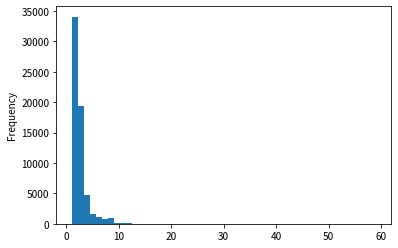

is_onechar: 2647
is_english: 4121
is_number: 33
is_special: 184
is_punctuation: 15


In [ ]:
# 針對字典 all_vocab_df 做一些統計
print(all_vocab_df['source'].value_counts())
print("\nlength range", all_vocab_df['length'].min(), all_vocab_df['length'].max())
print(all_vocab_df['length'].plot.hist(bins=50))
plt.show()
print(f"is_onechar: {(all_vocab_df['is_onechar'] == 1).sum()}")
print(f"is_english: {(all_vocab_df['is_english'] == 1).sum()}")
print(f"is_number: {(all_vocab_df['is_number'] == 1).sum()}")
print(f"is_special: {(all_vocab_df['is_special'] == 1).sum()}")
print(f"is_punctuation: {(all_vocab_df['is_punctuation'] == 1).sum()}")

In [194]:
all_vocab_df[all_vocab_df['length'] > 15]

,term,freq,source,length,is_onechar,is_english,is_number,is_special,is_punctuation
13499,samsungs6/s7/s8/s9/s10,8,both,22,False,False,False,False,False
15721,max/xr/x/8/8plus,6,both,16,False,False,False,False,False
19097,jeanmariesantantoni,5,both,19,False,True,False,False,False
21006,iphone/ipad/android,4,both,19,False,False,False,False,False
24066,hydroxyundecanoic,3,both,17,False,True,False,False,False
29108,methoxycinnamate,2,both,16,False,True,False,False,False
29356,avier-colormixpd,2,desc,16,False,False,False,False,False
30795,non-comedogenicity,2,both,18,False,False,False,False,False
32273,panasonicxultraman,2,both,18,False,True,False,False,False
36657,d-upwondereyelidtape,2,desc,20,False,False,False,False,False


In [192]:
all_vocab_df[all_vocab_df['is_onechar'] == 1]

,term,freq,source,length,is_onechar,is_english,is_number,is_special,is_punctuation
0,的,27380,both,1,True,False,False,False,False
1,不,12792,both,1,True,False,False,False,False
4,可,9856,both,1,True,False,False,False,False
8,g,7826,both,1,True,True,False,False,False
9,多,7532,both,1,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
62906,🌿,1,both,1,True,False,False,True,False
62907,🌎,1,both,1,True,False,False,True,False
62908,❗,1,both,1,True,False,False,True,False
62943,╳,1,both,1,True,False,False,True,False


In [195]:
all_vocab_df[all_vocab_df['is_english'] == 1]

,term,freq,source,length,is_onechar,is_english,is_number,is_special,is_punctuation
3,ml,9893,both,2,False,True,False,False,False
8,g,7826,both,1,True,True,False,False,False
29,cm,3373,both,2,False,True,False,False,False
93,x,1650,both,1,True,True,False,False,False
136,b,1338,both,1,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...
62882,vavacoco,1,desc,8,False,True,False,False,False
62909,frl,1,desc,3,False,True,False,False,False
62941,babybear,1,desc,8,False,True,False,False,False
62956,creamy,1,desc,6,False,True,False,False,False


In [196]:
all_vocab_df[all_vocab_df['is_number'] == 1]

,term,freq,source,length,is_onechar,is_english,is_number,is_special,is_punctuation
4076,2,47,both,1,True,False,True,False,False
5696,3,29,both,1,True,False,True,False,False
12762,13,9,both,2,False,False,True,False,False
13436,1,8,both,1,True,False,True,False,False
15669,8,6,both,1,True,False,True,False,False
15944,1945,6,both,4,False,False,True,False,False
16048,12,6,both,2,False,False,True,False,False
16405,04,6,both,2,False,False,True,False,False
19885,212852675,4,both,9,False,False,True,False,False
22509,3.1,4,both,3,False,False,True,False,False


In [197]:
all_vocab_df[all_vocab_df['is_special'] == 1]

,term,freq,source,length,is_onechar,is_english,is_number,is_special,is_punctuation
27,+,3558,both,1,True,False,False,True,False
85,$,1736,both,1,True,False,False,True,False
100,~,1577,both,1,True,False,False,True,False
235,●,876,both,1,True,False,False,True,False
410,★,563,both,1,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...
62842,🥇,1,both,1,True,False,False,True,False
62906,🌿,1,both,1,True,False,False,True,False
62907,🌎,1,both,1,True,False,False,True,False
62908,❗,1,both,1,True,False,False,True,False


In [198]:
all_vocab_df[all_vocab_df['is_punctuation'] == 1]

,term,freq,source,length,is_onechar,is_english,is_number,is_special,is_punctuation
2031,/,114,both,1,True,False,False,True,True
3328,&,61,both,1,True,False,False,True,True
5595,-,30,both,1,True,False,False,True,True
6995,·,22,both,1,True,False,False,True,True
14653,．,7,both,1,True,False,False,True,True
18626,］,5,both,1,True,False,False,True,True
18838,•,5,both,1,True,False,False,True,True
24012,--,3,both,2,False,False,False,True,True
25604,‧,3,both,1,True,False,False,True,True
26642,.,3,both,1,True,False,False,True,True


In [187]:
# 儲存字典 save all_vocab_df
all_vocab_df.to_csv(f'{DATA_DIR}/SalePage_vocab.csv', index=False)

### end

In [199]:
ptr = None
gc.collect()

39097